In [1]:
import datasets as ds
import regex
from pprint import pprint

/home/kkafara/.cache/virtualenvs/python-3.11-venv-ds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'clarin-knext/fiqa-pl'
dataset_config_name = 'corpus'

In [3]:
ds.get_dataset_split_names(dataset_name, dataset_config_name)

['corpus']

In [4]:
ds.get_dataset_config_names(dataset_name)

['corpus', 'queries']

In [5]:
whole_ds = ds.load_dataset(dataset_name, dataset_config_name)
whole_ds

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 57638
    })
})

In [6]:
corpus = whole_ds['corpus']
corpus

Dataset({
    features: ['_id', 'title', 'text'],
    num_rows: 57638
})

In [7]:
text_column = corpus['text']
print(type(text_column))

<class 'list'>


In [8]:
text_column[0]

'Nie mówię, że nie podoba mi się też pomysł szkolenia w miejscu pracy, ale nie możesz oczekiwać, że firma to zrobi. Szkolenie pracowników to nie ich praca – oni tworzą oprogramowanie. Być może systemy edukacyjne w Stanach Zjednoczonych (lub ich studenci) powinny trochę martwić się o zdobycie umiejętności rynkowych w zamian za ich ogromne inwestycje w edukację, zamiast wychodzić z tysiącami zadłużonych studentów i narzekać, że nie są do niczego wykwalifikowani.'

## Zadania 1 i 2

Wyrażenie regularne rozpoznające "godzinę" / "czas".

Chcę rozpoznawać specyfikacje czasu typu:

* 20:30
* 20:30:15
* 07:30
* 7:30:15
* 7:30:05
* 7:05:05

Czyli zakładam, że poszczególne części są oddzielone `:`, bez spacji, godzina może być jednocyfrowa, minuty / sekundy zawsze w formacie dwucyfrowym.

Dobrze byłoby pewnie też założyć jakieś ograniczenia na wartości (godzina $\in [0, 24)$, minuty $\in [0, 60)$, itd.). ~~Na razie tego nie robię, popatrzę na wyniki,
jeżeli będą łapać się rzeczy których nie chcemy, to wtedy będę komplikował.~~

In [9]:
# basic_time_regex = regex.compile(r'(\d{1,2}:\d{2}(:\d{2})?)')
templ = r'((([0-1]?[0-9])|(2[0-3])):[0-5][0-9](:[0-5][0-9])?)'
time_regex = regex.compile(templ)

In [10]:
time_matches = []
for paragraph in text_column:
    match = regex.findall(time_regex, paragraph)
    if match is not None and len(match) != 0:
        time_matches.extend(map(lambda cg: cg[0], match)) # We re interested only in first capture group 

# pprint(time_matches)
len(time_matches)

469

Wyrażenie regularne rozpoznające datę

Chcę rozpoznawać daty formatu:

1. dd/mm/yy
2. dd nazwa_miesiaca
3. d nazwa_miesiaca

Takiego wyrażenia np. jak "we wrześniu" nie traktuję jako datę. 

Walidację zakresów (wartość dla dni, miesiący, lat) robię jedynie ogólnie, nie rozróżniam dla poszczególnych miesięcy. Takie rzeczy można później łatwo
odfiltrować "normalnie w kodzie" bez kombinowania z regexami.
Regexa tworzę też tak, żeby uniknąć obsługi polskich znaków diakrytycznych. Sprawdziłem tylko, że `\w` w Pythonie (w `regex`) "łapie" polskie znaki.

In [11]:
# Testowałem z (([0-2][1-9])|(3[0-1]))|([1-9])) zamiast \d{1,2} -- ten sam wynik
templ = r'((\d{1,2}\s+(stycz|lut|mar[cz]|kwie|maj|czerw|lip|sierp|wrze(si|śn)|paźd|listopad|grud)\w+)|((([0-2][1-9])|(3[0-1]))/((0[1-9])|(1[0-2]))/\d{2}))'
basic_date_regex = regex.compile(templ, regex.IGNORECASE)

In [12]:
date_matches = []
for paragraph in text_column:
    match = regex.findall(basic_date_regex, paragraph)
    if match is not None and len(match) != 0:
        date_matches.extend(map(lambda cg: cg, match)) # Removing output of second capture group
        # print(match)
# pprint(date_matches)
len(date_matches)

2100

## Zadanie 3

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from collections import defaultdict

In [14]:
def count_hour_appearances(time_matches: list[str]) -> dict[str, int]:
    counts = defaultdict(int)
    for match in time_matches:
        hour = match.split(':')[0]
        if len(hour) == 1:
            hour = '0' + hour
        counts[hour] += 1
    return counts

        
hour_count = count_hour_appearances(time_matches)
items = list(hour_count.items())
df_time = pl.DataFrame({
    'hour': pl.Series(map(lambda kv: kv[0], items)),
    'count': pl.Series(map(lambda kv: kv[1], items))
}).sort(pl.col('hour'))
# df_time

In [15]:
unclassified_label = 'zother'
month_prefixes = ['stycz','lut','mar','kwie','maj','czerw','lip','sierp','wrze','paźd','listopad','grud']
month_mapping = {
    num: prefix for num, prefix in zip([str(m) if m >= 10 else '0' + str(m) for m in range(1, 12 + 1)], month_prefixes)
}

def find_month_prefix_for_match(match: str) -> str | None:
    for prefix in month_prefixes:
        if match.startswith(prefix):
            return prefix
    return unclassified_label

def count_month_appearances(date_matches: list[tuple[str, str, str, str]]) -> dict[str, int]:
    counts = defaultdict(int)
    for match in date_matches:
        if match[4] != '' and int(match[4].split('/')[1]) not in range(0, 13):
            print(match[3])
        month = find_month_prefix_for_match(match[2].lower()) if match[2] != '' else month_mapping.get(match[4].split('/')[1], unclassified_label)
        counts[month] += 1
    return counts


month_count = count_month_appearances(date_matches)
items = sorted(list(month_count.items()), key=lambda kv: month_prefixes.index(kv[0]) if kv[0] != unclassified_label else 99)
df_date = pl.DataFrame({
    'month': pl.Series(map(lambda kv: kv[0], items)),
    'count': pl.Series(map(lambda kv: kv[1], items))
})

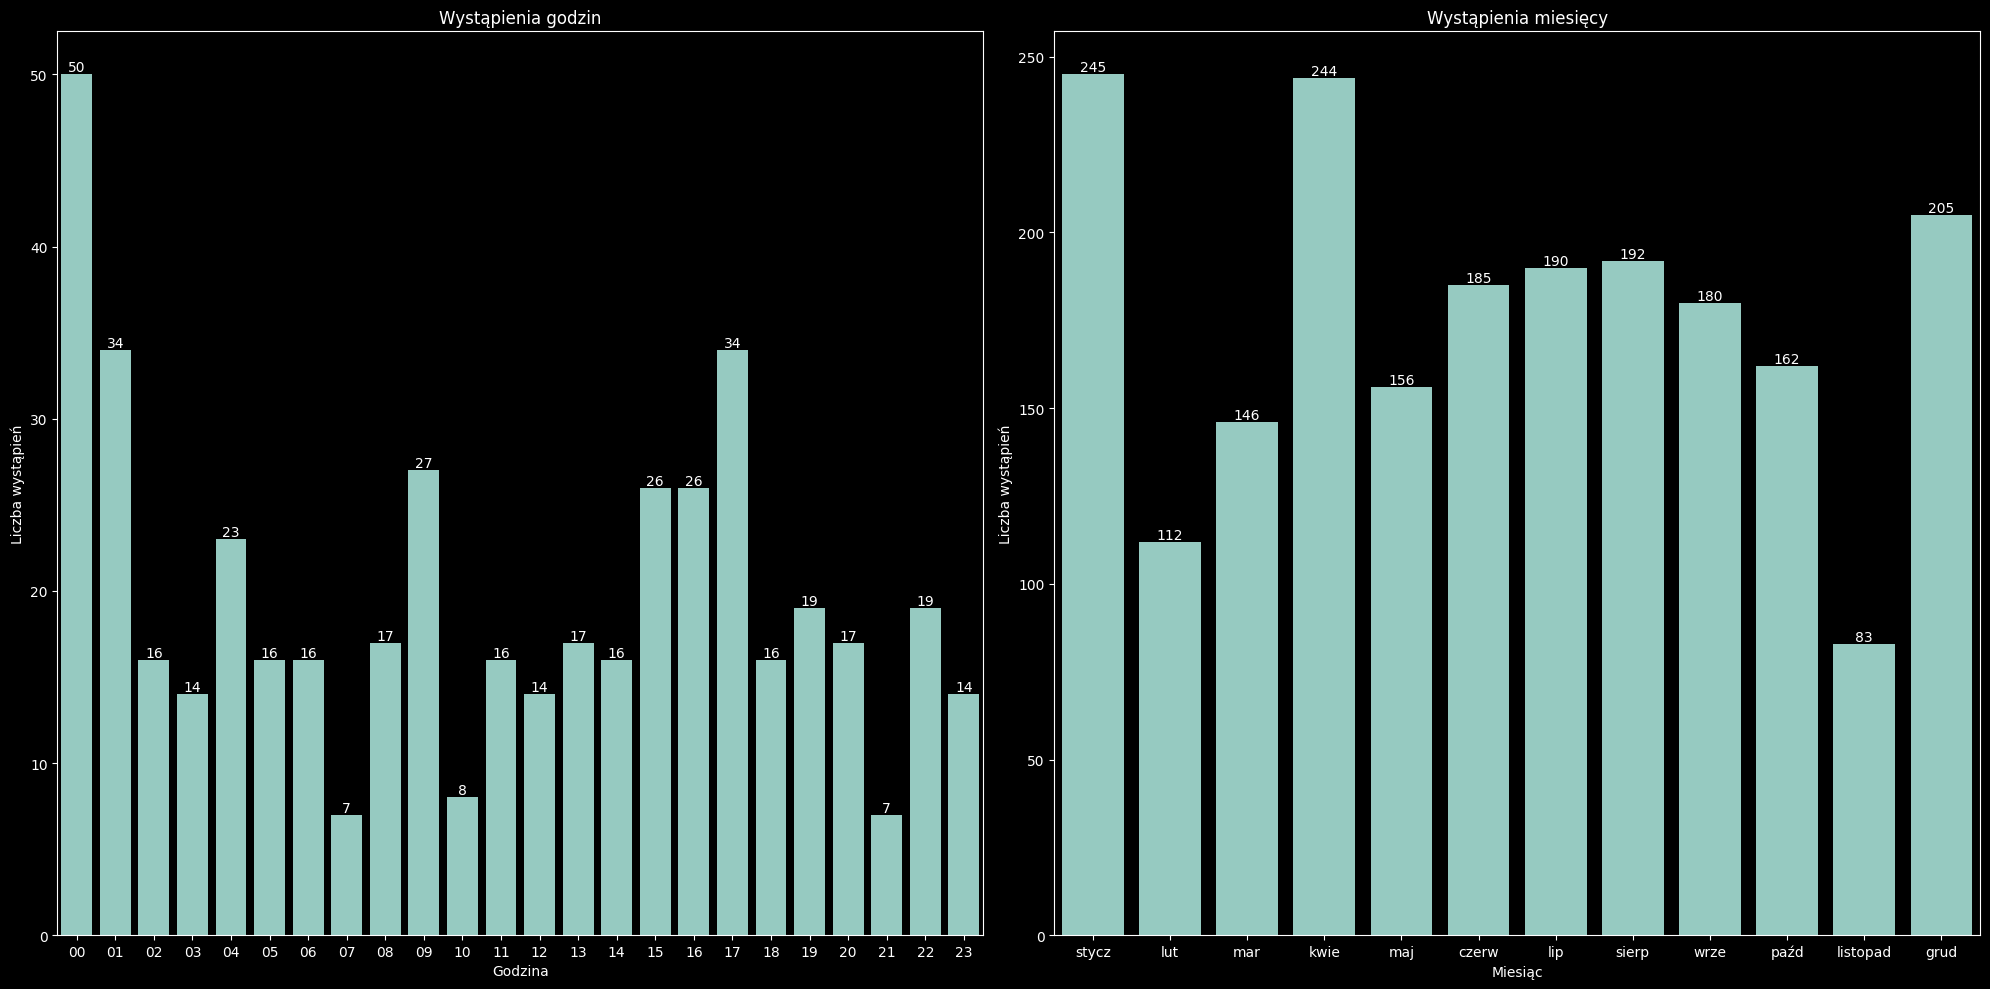

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.barplot(data=df_time, x='hour', y='count', ax=ax[0])
sns.barplot(data=df_date, x='month', y='count', ax=ax[1])
ax[0].bar_label(ax[0].containers[0])
ax[1].bar_label(ax[1].containers[0])
ax[0].set(
    title='Wystąpienia godzin',
    xlabel='Godzina',
    ylabel='Liczba wystąpień'
)
ax[1].set(
    title='Wystąpienia miesięcy',
    xlabel='Miesiąc',
    ylabel='Liczba wystąpień'
)
fig.tight_layout()

## Zadania 4, 5, 6

In [17]:
jan_regex_base = regex.compile(r'\bstycz\w+', regex.IGNORECASE)

# Dowolna liczba przed miesiącem, nie zawężam (nie jest wyspecyfikowane w poleceniu + nie chcę gubić)
jan_regex_num_space = regex.compile(r'\d+ \bstycz\w+', regex.IGNORECASE)
jan_regex_not_num_space = regex.compile(r'(?<!\d+ )\bstycz\w+', regex.IGNORECASE)

In [18]:
jan_matches_base = []
jan_matches_num_space = []
jan_matches_not_num_space = []

for paragraph in text_column:
    match = regex.findall(jan_regex_base, paragraph)
    if match is not None and len(match) > 0:
        jan_matches_base.extend(match)

    match = regex.findall(jan_regex_num_space, paragraph)
    if match is not None and len(match) > 0:
        jan_matches_num_space.extend(match)

    match = regex.findall(jan_regex_not_num_space, paragraph)
    if match is not None and len(match) > 0:
        # print(match)
        jan_matches_not_num_space.extend(match)

print(f'Podstowowe: {len(jan_matches_base)}, liczba+spacja: {len(jan_matches_num_space)}, bez liczby+spacji: {len(jan_matches_not_num_space)}, razem (not)?liczba+spacja: {len(jan_matches_num_space) + len(jan_matches_not_num_space)}')
print("Zgadza się" if len(jan_matches_base) == len(jan_matches_not_num_space) + len(jan_matches_num_space) else "Nie zgadza się")

Podstowowe: 508, liczba+spacja: 215, bez liczby+spacji: 293, razem (not)?liczba+spacja: 508
Zgadza się


## Pytania

### Czy wyrażenia regularne są dobre w wychwytywaniu czasu / dat

Nie. Żeby stworzyć sensowne wyrażenie regularne trzeba zaplanować jakie postaci wyrażeń będzie się chciało odnajdywać. W przypadku czasu / dat, w języku 
naturlanym istnieje mnogość form w jakich czas / data może być wyrażona. W takiej sytuacji bardzo łatwo zgubić jakiś przypadek. Ja np. nie uwzględniałem dat
wyrażonych słownie, np. "pierwszego września", "dziesiątego października" (godziny podobnie), prawdopodobnie gubiąc jakieś przypadki z zbioru danych.
Nie uwzglęniam także literówek, np. zamiast "30 grudnia", "30 gurdnia". Przez moje regexy przejdą także daty niepoprawne,
np. 31/02/23, bądź w ogóle nie daty: "22 marchewki". Stworzenie wyrażenia regularnego obsługującego to jest możliwe (doklejając kolejne alternatywy dla każdego z miesięcy), natomiast robienie
tego regexem jest pozbawione sensu (chyba, że nie ma innej możliwości).
Pominiętych przeze mnie przypadków jest jeszcze więcej, więc powtarzam: robienie tego regexem to ostateczność. Myślę, że regexy nadają się lepiej
do przeszukiwania bardziej uporządkowanych danych np. logów.

### Jak upewnić się że znaleziono wszystkie wyrażenia danego typu i tylko wyrażenia danego typu?

Nie sądzę by był taki sposób. Jeżeli zbiór danych jest mały -- oczywiście możemy zweryfikować to manualnie 
(tak też zobaczyłem, że w zadaniach 4-6 dopasowywało mi `styczna`, choć słowo to nie jest związane ze styczniem...). Możemy też porównać się 
z wynikami zwróconymi przez inne narzędzia (np. modele językowe). Natomiast gdyby istniał sposób dający poprawne wyniki, 
do których moglibyśmy się odnieść w celu porównania to nie używalibyśmy regexów.


### Odnośnie zadań 4-6

Nie jestem zdziwiony, że się zgadza, bo te dwa węższe regexy (z liczbą i bez liczby) dopełniają się do podstawowego. Natomiast zdaję sobie sprawę, że mój regex
zbiera też takie słowa jak `styczna`, `stycznej` itd. (z liczbami i bez).
